<a href="https://colab.research.google.com/github/tommyEzreal/handmade_transformer/blob/main/transformer_from_scratch(middle_level).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

code from https://www.youtube.com/watch?v=U0s0f995w14:

In [1]:
import torch
import torch.nn as nn

In [2]:
# einsum()
import numpy as np

# transpose Rij = Aji
A = np.array([[1,2,3],[4,5,6]])
R = np.einsum("ij->ji",A)
print(A)
print(R)

[[1 2 3]
 [4 5 6]]
[[1 4]
 [2 5]
 [3 6]]


## Self Attention

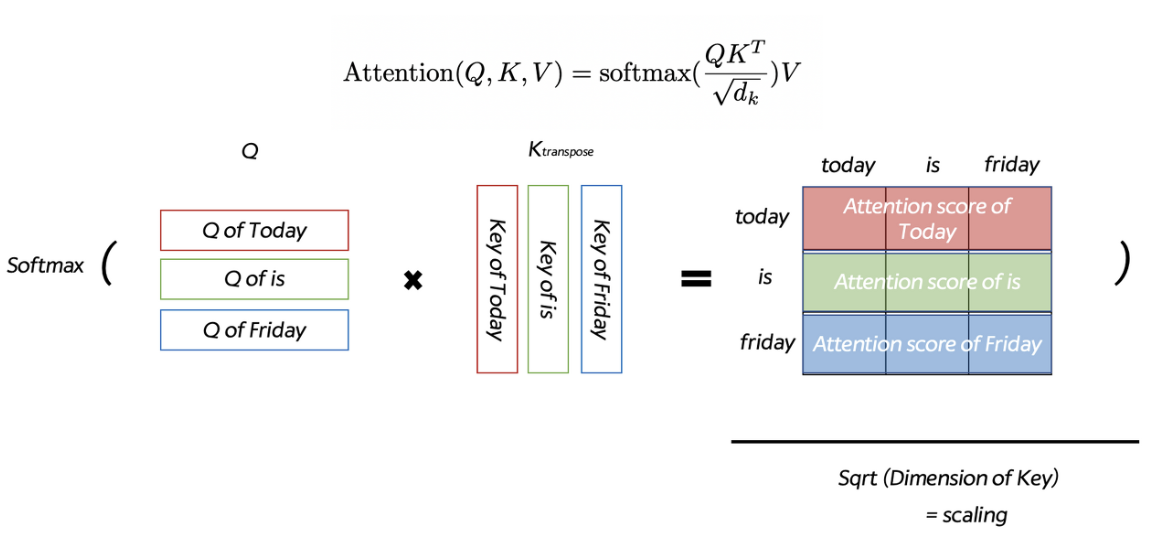

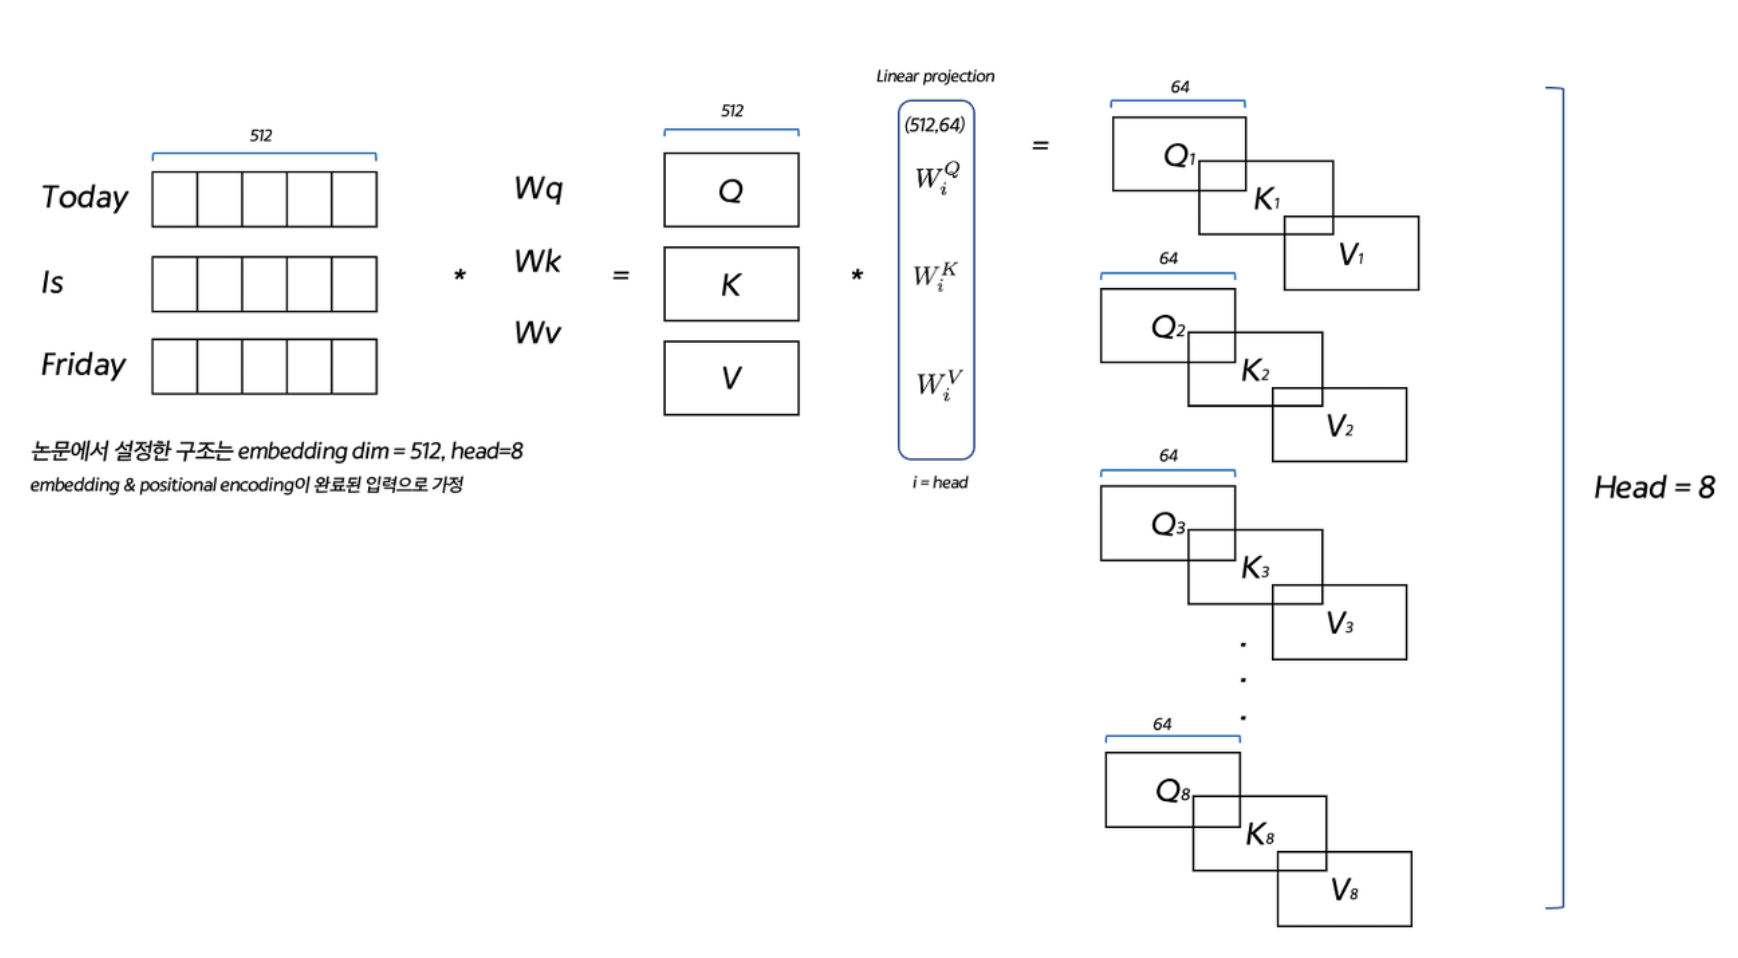

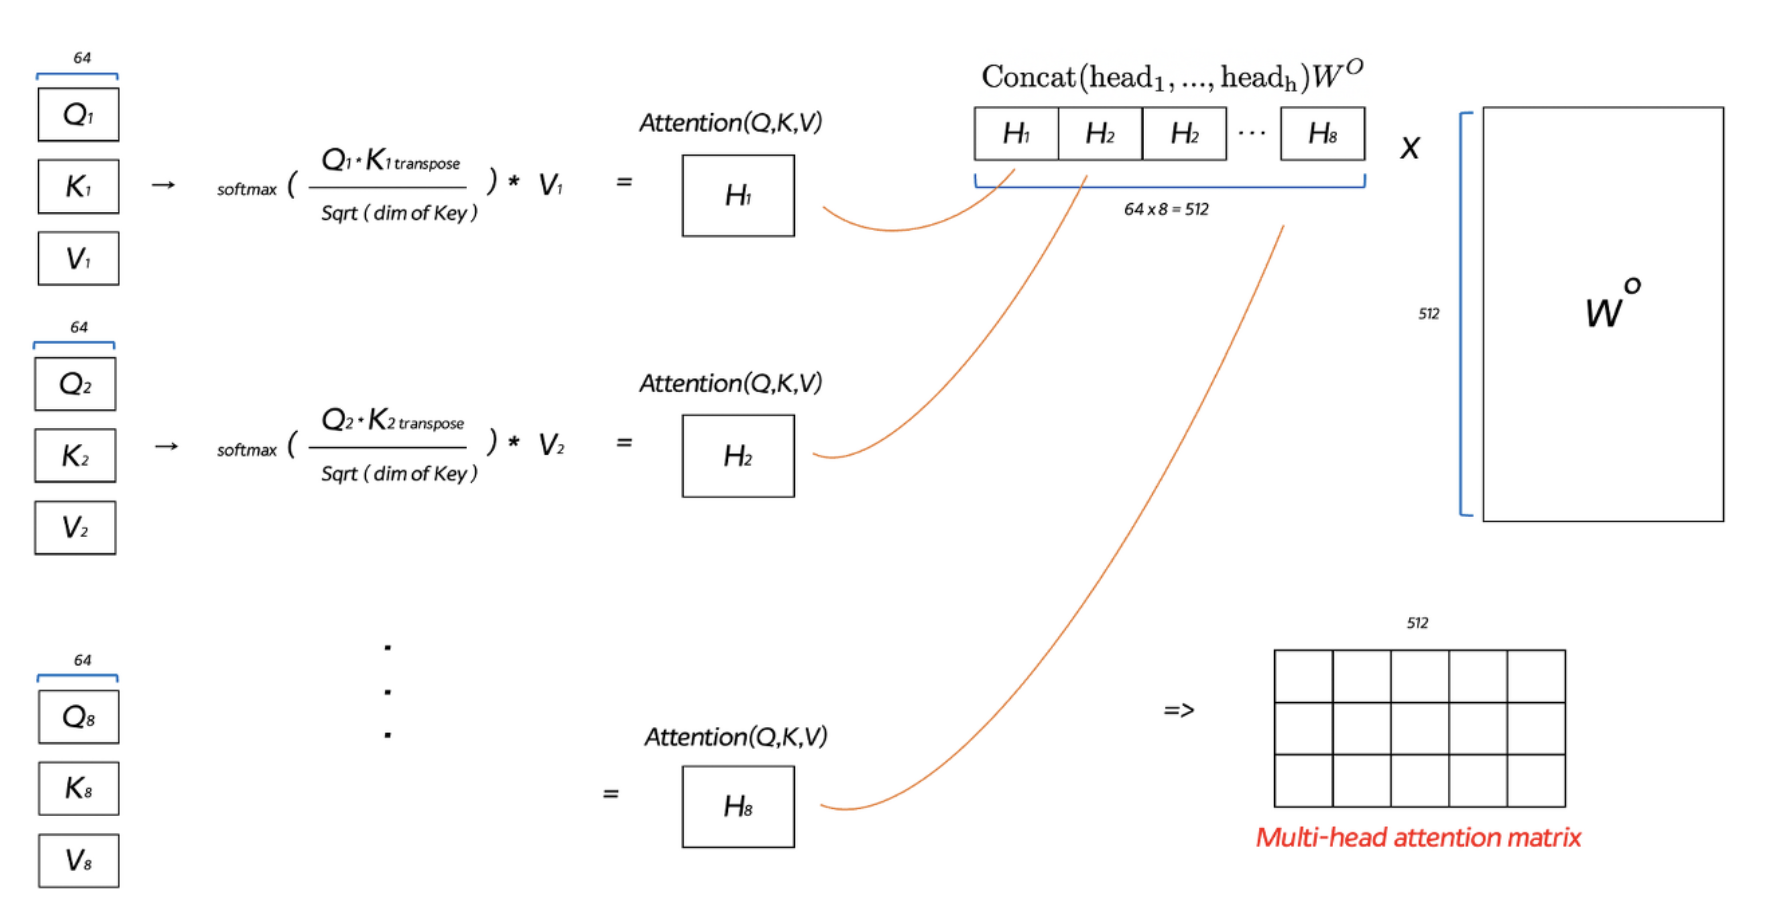

In [71]:
class SelfAttention(nn.Module):
  def __init__(self, embed_size, heads):
    super(SelfAttention, self).__init__()
    self.embed_size = embed_size
    self.heads = heads
    self.head_dim = embed_size // heads

    assert (self.head_dim * heads == embed_size), "Embed size needs to be div by heads"

    self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
    self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
    self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
    self.fc_out = nn.Linear(heads * self.head_dim, embed_size) # =(embed_size, embed_size)

  def forward(self, values, keys, query, mask):
    N = query.shape[0]
    value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

    # split embedding into self.heads pieces

    values = values.reshape(N, value_len, self.heads, self.head_dim)
    keys = keys.reshape(N, key_len, self.heads, self.head_dim)
    queries = query.reshape(N, query_len, self.heads, self.head_dim)

    values = self.values(values)
    keys = self.keys(keys)
    queries = self.queries(queries)


    """
    # queries shape: (N, query_len, heads, heads_dim)
    # keys shape: (N, key_len, heads, heads_dim)
    # energy shape : (N, heads, query_len, key_len)
    """
    # einsum : instead of matmul 
    energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])

    if mask is not None: # masking 
      energy = energy.masked_fill(mask == 0, float("-1e20"))
    
    """
    attention shape : (N, heads, query_len, key_len)
    values shape : (N, value_len, heads, heads_dim)
    after einsum (N, query, heads, head_dim), flatten last two dim 
    """
    attention = torch.softmax(energy / self.embed_size ** (1/2), dim=3)
    out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
        N, query_len, self.heads * self.head_dim
    )# concat

    out = self.fc_out(out)
    return out 
    

## Transformer Block

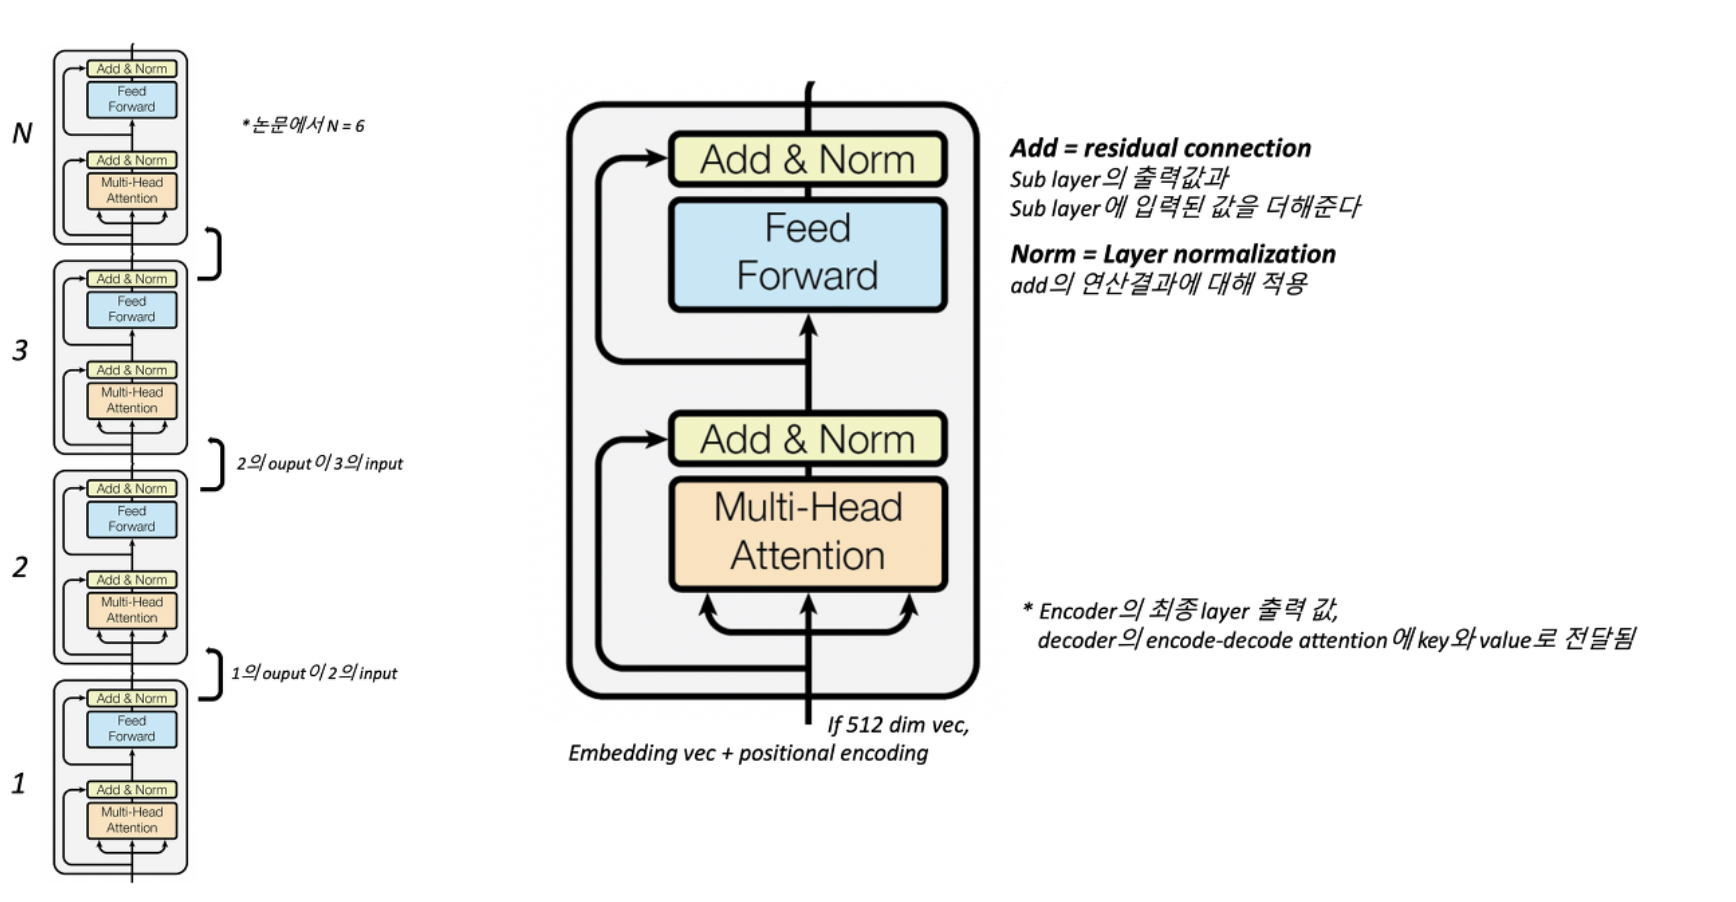

In [52]:
class TransformerBlock(nn.Module):
  def __init__(self, embed_size, heads, dropout, forward_expansion):
    super(TransformerBlock, self).__init__()
    self.attention = SelfAttention(embed_size, heads)
    self.norm1 = nn.LayerNorm(embed_size)
    self.norm2 = nn.LayerNorm(embed_size)

    self.feed_forward = nn.Sequential(
        nn.Linear(embed_size, forward_expansion * embed_size),
        nn.ReLU(),
        nn.Linear(forward_expansion*embed_size, embed_size)
    )

    self.dropout = nn.Dropout(dropout)
  
  def forward(self, value, key, query, mask):
    attention = self.attention(value, key, query, mask)

    x = self.dropout(self.norm1(attention + query)) # ? 
    forward = self.feed_forward(x)
    out = self.dropout(self.norm2(forward + x)) # ? 
    return out

Encoder

In [53]:
class Encoder(nn.Module):
  def __init__(self,
             src_vocab_size,
             embed_size,
             num_layers,
             heads,
             device,
             forward_expansion,
             dropout,
             max_length):
    super(Encoder, self).__init__()
    
    self.embed_size = embed_size
    self.device = device
    self.word_embedding = nn.Embedding(src_vocab_size, embed_size)
    self.position_embedding = nn.Embedding(max_length, embed_size)

    self.layers = nn.ModuleList(
        [
            TransformerBlock(
                embed_size,
                heads,
                dropout = dropout, 
                forward_expansion = forward_expansion
            )
        for _ in range(num_layers)]
    ) 
    self.dropout = nn.Dropout(dropout)

  def forward(self, x , mask):
    N, seq_length = x.shape
    positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)

    out = self.dropout(self.word_embedding(x) + self.position_embedding(positions))

    for layer in self.layers:
      out = layer(out, out, out, mask)
    
    return out

In [34]:
N, seq_len = torch.LongTensor([[1,2,3],[4,5,6]]).shape

torch.arange(0,seq_len).expand(N, seq_len)

tensor([[0, 1, 2],
        [0, 1, 2]])

Decoder

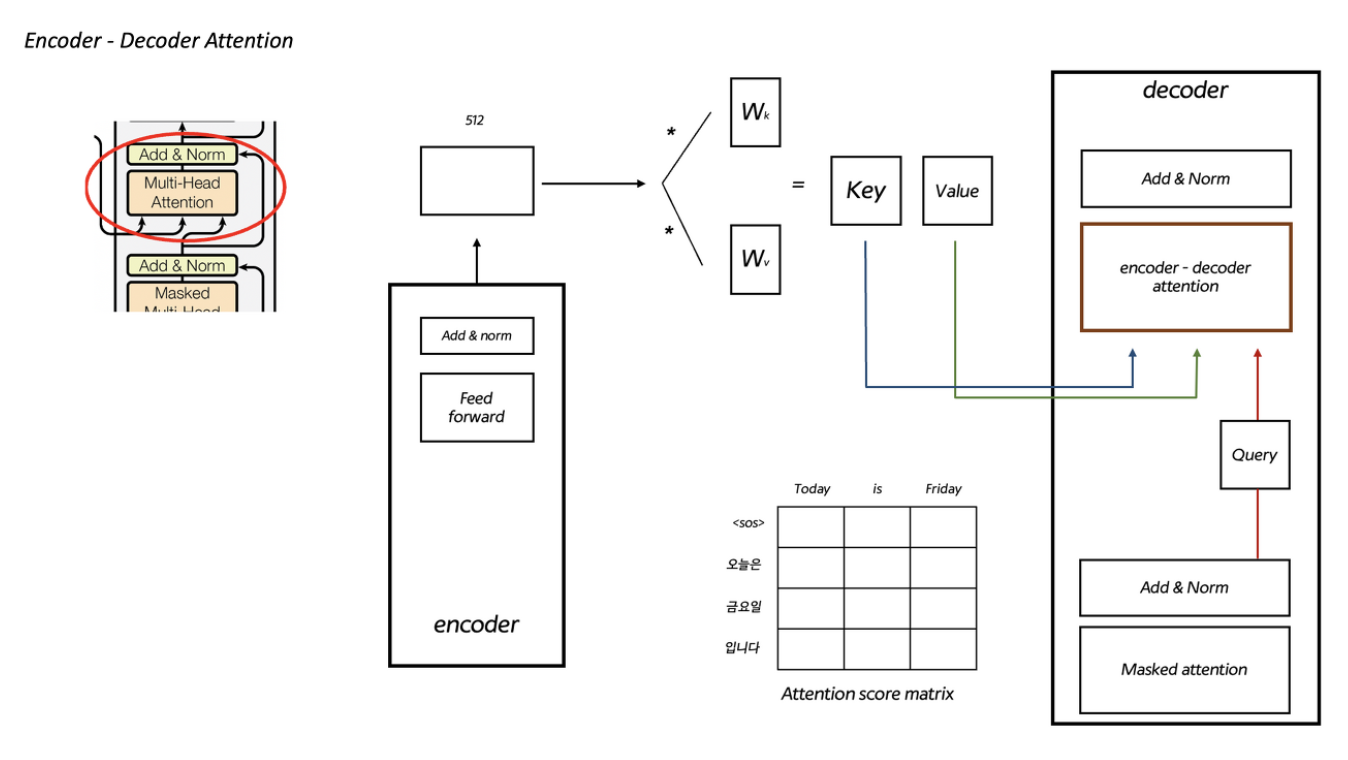

In [54]:
class DecoderBlock(nn.Module):
  def __init__(self, embed_size, heads, forward_expansion, dropout, device):
    super(DecoderBlock, self).__init__()
    self.attention = SelfAttention(embed_size, heads)
    self.norm = nn.LayerNorm(embed_size)
    self.transformer_block = TransformerBlock(
        embed_size, heads, dropout, forward_expansion
    )
    self.dropout = nn.Dropout(dropout)

  def forward(self, x, value, key, src_mask, trg_mask):
    attention = self.attention(x,x,x, trg_mask)
    query = self.dropout(self.norm(attention + x))
    out = self.transformer_block(value, key, query, src_mask)
    return out


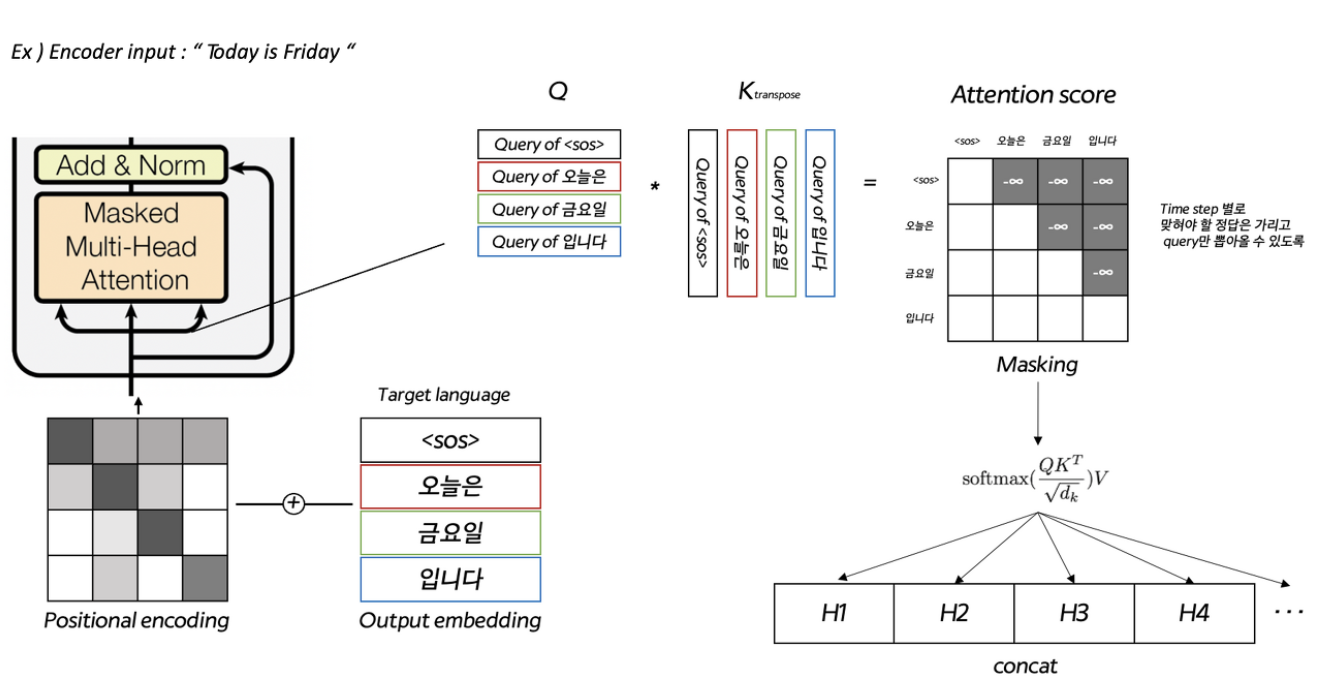

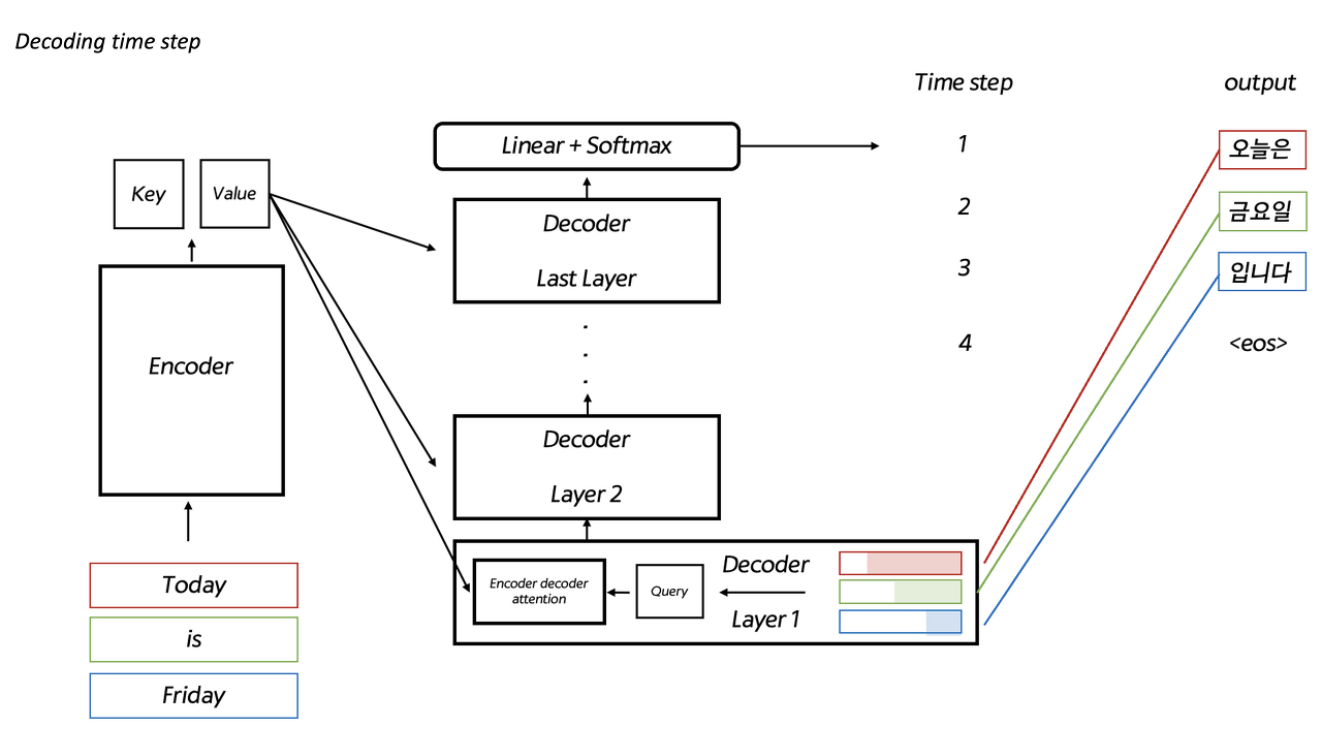

In [78]:
class Decoder(nn.Module):
  def __init__(self,
               trg_vocab_size,
               embed_size,
               num_layers,
               heads,
               forward_expansion,
               dropout,
               device,
               max_length):
    super(Decoder, self).__init__()
    self.device = device
    self.word_embedding = nn.Embedding(trg_vocab_size, embed_size)
    self.position_embedding = nn.Embedding(max_length, embed_size)
    self.layers = nn.ModuleList(
        [DecoderBlock(embed_size, heads, forward_expansion, dropout, device)
        for _ in range(num_layers)]
    )
    self.fc_out = nn.Linear(embed_size, trg_vocab_size)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x, enc_out, src_mask, trg_mask):
    N, seq_length = x.shape
    positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
    x = self.dropout((self.word_embedding(x))+ self.position_embedding(positions))

    for layer in self.layers:
      x = layer(x, enc_out, enc_out, src_mask, trg_mask)
    
    out = self.fc_out(x)
    return out


combine

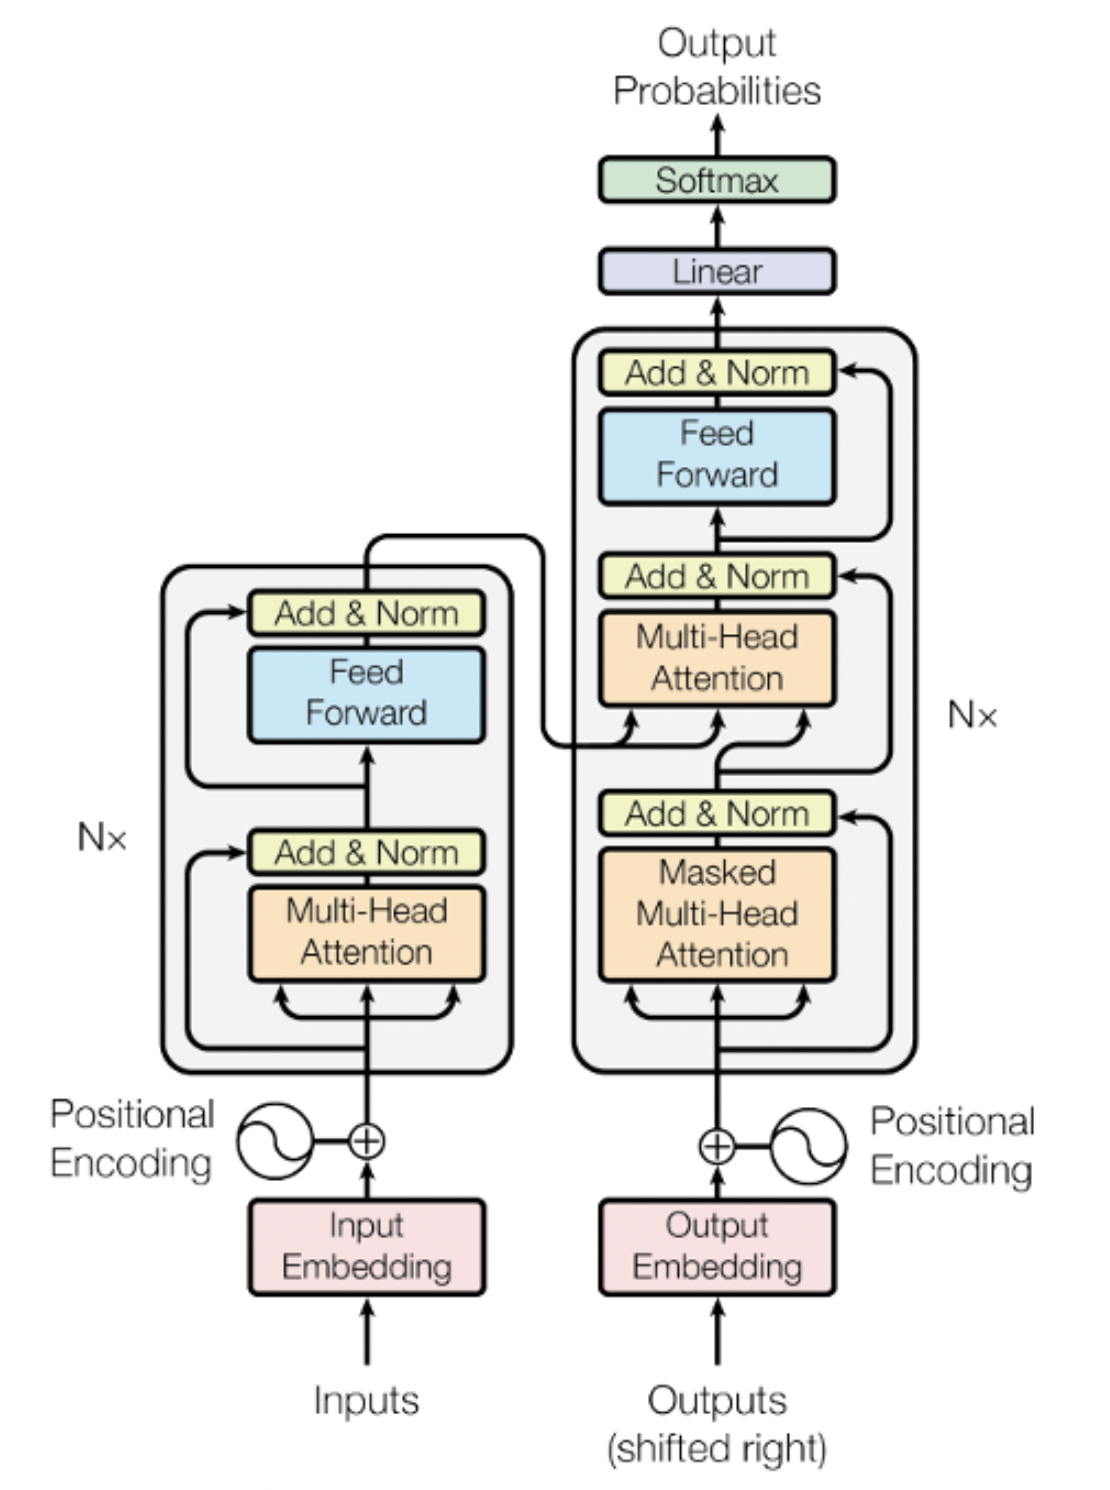

In [103]:
class Transformer(nn.Module):
  def __init__(self,
               src_vocab_size,
               trg_vocab_size,
               src_pad_idx,
               trg_pad_idx,
               embed_size= 256,
               num_layers =6,
               forward_expansion = 4,
               heads = 8,
               dropout = 0,
               device = "cuda",
               max_length = 128): 
    super(Transformer, self).__init__()

    self.encoder = Encoder(src_vocab_size,
                           embed_size,
                           num_layers,
                           heads,
                           device,
                           forward_expansion,
                           dropout,
                           max_length)
    self.decoder = Decoder(trg_vocab_size,
                           embed_size,
                           num_layers,
                           heads,
                           forward_expansion,
                           dropout,
                           device,
                           max_length)

    self.src_pad_idx = src_pad_idx
    self.trg_pad_idx = trg_pad_idx
    self.device = device


  def make_src_mask(self, src):
    src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2) # ?
    return src_mask.to(self.device)

  def make_trg_mask(self, trg):
    N, trg_len = trg.shape
    trg_mask = torch.tril(torch.ones((trg_len, trg_len))).expand(
        N, 1, trg_len, trg_len
    )
    return trg_mask.to(self.device)

  def forward(self, src, trg):
    src_mask = self.make_src_mask(src)
    trg_mask = self.make_trg_mask(trg)
    enc_src = self.encoder(src, src_mask) # with src mask 
    out = self.decoder(trg, enc_src, src_mask, trg_mask) # put it into decoder
    return out 

In [107]:
model = Transformer(10,10,0,0).to(device)

src = torch.tensor([[1,3,3,2,0,0],[1,4,5,6,2,0]]).to(device)
print(src)

print(model.make_src_mask(src))

tensor([[1, 3, 3, 2, 0, 0],
        [1, 4, 5, 6, 2, 0]], device='cuda:0')
tensor([[[[ True,  True,  True,  True, False, False]]],


        [[[ True,  True,  True,  True,  True, False]]]], device='cuda:0')


In [108]:
trg = torch.tensor([[1,4,3,2,0],[1,3,5,2,0]]).to(device)
print(trg)
print(model.make_trg_mask(trg))

tensor([[1, 4, 3, 2, 0],
        [1, 3, 5, 2, 0]], device='cuda:0')
tensor([[[[1., 0., 0., 0., 0.],
          [1., 1., 0., 0., 0.],
          [1., 1., 1., 0., 0.],
          [1., 1., 1., 1., 0.],
          [1., 1., 1., 1., 1.]]],


        [[[1., 0., 0., 0., 0.],
          [1., 1., 0., 0., 0.],
          [1., 1., 1., 0., 0.],
          [1., 1., 1., 1., 0.],
          [1., 1., 1., 1., 1.]]]], device='cuda:0')


In [114]:
src_mask = model.make_src_mask(src) 
trg_mask = model.make_trg_mask(trg)

enc_src = model.encoder(src, src_mask)
print(enc_src)

out = model.decoder(trg, enc_src, src_mask, trg_mask)
print(out.shape)

tensor([[[ 1.3587,  0.4207, -0.6868,  ...,  0.7583,  0.0044,  1.2132],
         [ 2.0872,  0.2008, -0.7132,  ..., -0.8406, -0.1961,  1.0049],
         [ 2.2821, -0.6458, -0.5182,  ...,  0.9939, -0.1730, -1.5242],
         [ 0.6569,  0.0205, -0.2019,  ...,  0.4244, -0.5333,  0.1016],
         [ 0.4603,  1.0119, -2.5493,  ...,  0.2273,  0.0675,  0.9378],
         [ 1.0198,  0.8397, -0.9716,  ...,  0.3131,  0.1256,  2.1980]],

        [[ 0.7039,  0.4368, -0.1663,  ...,  0.4871,  0.2221,  0.4780],
         [ 1.6515,  1.7449, -0.4731,  ..., -0.4966,  0.0671,  0.2378],
         [-0.3564, -0.0712, -0.3377,  ...,  0.8100,  0.2615, -2.6865],
         [ 0.4452, -0.3358,  0.4671,  ...,  0.4604, -0.0342, -1.0777],
         [-0.5480,  0.5418, -0.6007,  ..., -1.1864, -0.7523,  0.2854],
         [ 0.5719,  0.9265, -0.5470,  ..., -0.0995,  0.3736,  1.9420]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)
torch.Size([2, 8, 10])


In [109]:
# see if it works

if __name__ == "__main__":  
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  x = torch.tensor([[1,5,6,4,3,9,5,2,0], [1,8,7,3,4,5,6,7,2]]).to(device) # src

  trg = torch.tensor([[1,7,4,3,5,9,2,0], [1,5,6,2,4,7,6,2]]).to(device) # trg

  src_pad_idx = 0
  trg_pad_idx = 0
  src_vocab_size = 10
  trg_vocab_size = 10

  #model 
  model = Transformer(src_vocab_size, trg_vocab_size, src_pad_idx, trg_pad_idx,).to(device)

  out = model(x, trg) # (src, trg)

In [88]:
out, out.shape

(tensor([[[-0.0968, -0.4450, -0.1758,  0.0419,  0.5195,  0.5564, -0.5108,
           -0.1276,  0.0736, -0.1758],
          [-0.1803,  0.2103,  0.2164,  0.5533,  0.0430,  0.4225,  0.3060,
            0.3428,  0.2216, -0.5709],
          [-0.1070,  0.5751,  1.3440, -0.3808,  1.0791,  0.4863, -0.0559,
            0.1682, -0.5349,  0.4167],
          [-0.2359, -0.0505,  0.7467, -0.3565,  0.0297,  0.3952, -0.9596,
            0.1239,  0.5828, -1.0226],
          [-0.1192, -0.6639,  0.4332, -0.3557,  0.6157, -0.4617, -1.0016,
           -1.3027, -0.1253,  0.5524],
          [-1.0709, -0.4074,  0.5852, -1.2893,  0.6433,  0.0565, -0.4239,
            0.1025, -0.5500,  0.4318],
          [-0.9652,  0.1013,  0.3583, -0.8719,  0.9679,  0.1311,  0.1178,
           -0.2808, -0.3915,  1.0142],
          [ 0.1919, -1.1031,  0.4452, -0.3446,  0.8017,  0.4520, -0.0802,
           -1.0470,  0.3232,  0.4339]],
 
         [[-0.4314, -0.7278, -0.3509,  0.0399,  0.2934,  0.5855, -0.4594,
            0.1687,